In [21]:
!pip install gym

In [23]:
import gym
import math
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple
from itertools import count
from PIL import Image

import torch as T
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np

In [24]:
import numpy as np
import matplotlib.pyplot as plt
import gym
from gym import spaces
import random
from google.colab import widgets
import time

#Deterministic Environment

In [25]:
class DeterministicEnv(gym.Env):
  metadata = {'render.modes':[]}
  def __init__(self):
    self.table_dim = 6
    self.observation_space = spaces.Discrete(self.table_dim*self.table_dim)
    self.action_space = spaces.Discrete(4)
    self.maxtimesteps=18 #change
    self.rewardStates = dict()

    for i in range(self.table_dim):
      for j in range(self.table_dim):
        self.rewardStates[(i,j)] = -1
    # t=1
    # for j in range(self.table_dim):
    #   self.rewardStates[(0,j)] = t
    #   t+=1
    # t=1
    # for i in range(self.table_dim):
    #   self.rewardStates[(self.table_dim-1,j)] = t
    #   t+=1

    t=0.1
    for j in range(self.table_dim):
      self.rewardStates[(0,j)] = t
      t+=0.1
    for i in range(self.table_dim):
      self.rewardStates[(self.table_dim-1,j)] = t
      t+=0.1

    self.rewardStates[(2,2)] = -1
    self.rewardStates[(1,4)] = -4
    self.rewardStates[(self.table_dim-1,self.table_dim-1)] = 100


  def reset(self):
    self.timesteps = 0
    self.agent_pos = [0,0]
    self.goal_pos = [self.table_dim-1,self.table_dim-1]
    self.state = np.zeros((self.table_dim,self.table_dim))
    self.state[tuple(self.agent_pos)] = 1
    self.state[tuple(self.goal_pos)] = 0.5
    self.state[2,2] = 0.3
    self.state[1,4] = 0.3
    observation = self.state.flatten()
    return self.agent_pos



  def step(self,action):
    self.state = np.random.choice(self.observation_space.n)

    if action == 0: #down
      self.agent_pos[0] +=1
    elif action==1: #up
      self.agent_pos[0] -=1
    elif action==2:#right
      self.agent_pos[1] += 1
    elif action==3: #left
      self.agent_pos[1] -= 1
    
    self.agent_pos = np.clip(self.agent_pos,0,self.table_dim-1)
    self.state = np.zeros((self.table_dim,self.table_dim))
    self.state[tuple(self.agent_pos)] = 1
    self.state[tuple(self.goal_pos)] = 0.5
    self.state[2,2] = 0.3
    self.state[1,4] = 0.3
    observation = self.state.flatten()
    reward = 0
    if tuple(self.agent_pos) in self.rewardStates: #Checking if agent is in reward position
      reward = self.rewardStates[tuple(self.agent_pos)]

    self.timesteps +=1
    done = False
    if (self.timesteps >= self.maxtimesteps) or (tuple(self.agent_pos) == tuple(self.goal_pos)):#Ensuring Safety in AI
      done = True 
    info = {}

    return self.agent_pos, reward, done, info



  def render(self):
    plt.imshow(self.state)

# DQN

In [26]:
class DeepQNetwork(nn.Module):
  def __init__(self,lr,fc1_dims,fc2_dims,n_actions):
    super(DeepQNetwork, self).__init__()
    self.fc1_dims = fc1_dims
    self.fc2_dims = fc2_dims
    self.n_actions = n_actions
    self.fc1 = nn.Linear(2,self.fc1_dims)
    self.fc2 = nn.Linear(self.fc1_dims, self.fc2_dims)
    self.fc3 = nn.Linear(self.fc2_dims, self.n_actions)
    self.optimizer = optim.Adam(self.parameters(),lr=lr)
    self.loss = nn.MSELoss()
    self.device = T.device('cuda:0' if T.cuda.is_available() else 'cpu')
    self.to(self.device)

  def forward(self, state):
      layer1 = F.relu(self.fc1(state.float()))
      layer2 = F.relu(self.fc2(layer1))
      actions = self.fc3(layer2)

      return actions

# Q-Learning Agent

In [27]:
class QlearningAgent:
    def __init__(self, env,batch_size,input_dims=2,epsilon=1.0,lr=0.6,gamma=0.9,n_actions=4,max_mem_size=1000):
        self.env = env
        self.observation_space = env.observation_space
        self.action_space = env.action_space
        q_table_dim = env.table_dim

        self.q_table = np.zeros((q_table_dim,q_table_dim,env.action_space.n))
        self.epsilon = epsilon
        self.lr = lr
        self.gamma = gamma

        self.action_space = [i for i in range(n_actions)]
        self.mem_size = max_mem_size
        self.batch_size = batch_size
        self.mem_ctr = 0

        self.Q_eval = DeepQNetwork(lr=self.lr,n_actions=n_actions,fc1_dims=16,fc2_dims=16) #change
        self.Q_eval_hat = DeepQNetwork(lr=self.lr,n_actions=n_actions,fc1_dims=16,fc2_dims=16) #change
        #self.Q_eval_new = DeepQNetwork(lr=self.lr,n_actions=n_actions,fc1_dims=256,fc2_dims=256) #change
        #self.Q_eval = self.Q_eval_new #Load state dictionary

        self.state_memory = np.zeros((self.mem_size,input_dims),dtype=np.double)
        self.new_state_memory = np.zeros((self.mem_size,input_dims),dtype=np.double)

        self.action_memory = np.zeros(self.mem_size, dtype=np.double)
        self.reward_memory = np.zeros(self.mem_size, dtype=np.double)
        self.terminal_memory = np.zeros(self.mem_size, dtype=np.bool)

    def store_transition(self, state, action, reward, state_, done):
      index = self.mem_ctr % self.mem_size
      self.state_memory[index] = state
      self.new_state_memory[index] = state_
      self.reward_memory[index] = reward
      self.action_memory[index] = action
      self.terminal_memory[index] = done

      self.mem_ctr+=1

    
    def policy(self,observation):

      if np.random.random() > self.epsilon:
        state = T.tensor([observation]).to(self.Q_eval.device)
        actions = self.Q_eval.forward(state)
        action = T.argmax(actions).item()
      else:
        action = np.random.choice(self.action_space)
      
      return action
     
    def step(self, observation):
        return self.policy(observation)
    
    def learn(self):
      if self.mem_ctr < self.batch_size:
        return
      
      self.Q_eval.optimizer.zero_grad()

      max_mem = min(self.mem_ctr,self.mem_size)
      batch = np.random.choice(max_mem,self.batch_size,replace=False)

      batch_index = np.arange(self.batch_size, dtype=np.double)

      state_batch = T.tensor(self.state_memory[batch]).to(self.Q_eval.device)
      new_state_batch = T.tensor(self.new_state_memory[batch]).to(self.Q_eval.device)
      reward_batch = T.tensor(self.reward_memory[batch]).to(self.Q_eval.device)
      terminal_batch = T.tensor(self.terminal_memory[batch]).to(self.Q_eval.device)

      action_batch = self.action_memory[batch]

      q_eval = self.Q_eval.forward(state_batch)[batch_index,action_batch]
      q_next = self.Q_eval.forward(new_state_batch)
      q_next[terminal_batch] = 0.0

      q_target = reward_batch + self.gamma*T.max(q_next,dim=1)[0]

      loss = self.Q_eval.loss(q_target,q_eval).to(self.Q_eval.device)
      # loss = self.Q_eval.loss(q_eval,q_target).to(self.Q_eval.device)
      loss.backward()
      self.Q_eval.optimizer.step()
    
    def setEpsilon(self,epsilon):
      self.epsilon = epsilon

# Q-Learning Deterministic

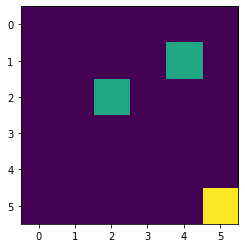

Episode 0
Epsilon 1.0
***************************************************


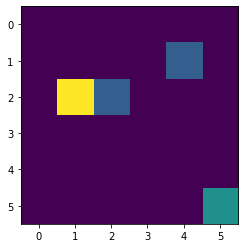

Episode 100
Epsilon 0.9047921471137096
***************************************************


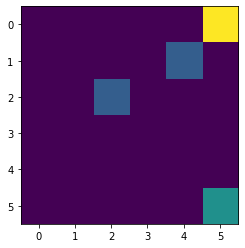

Episode 200
Epsilon 0.818648829478636
***************************************************


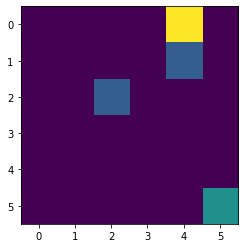

Episode 300
Epsilon 0.7407070321560997
***************************************************


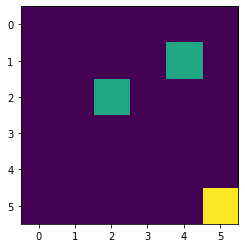

Episode 400
Epsilon 0.6701859060067403
***************************************************


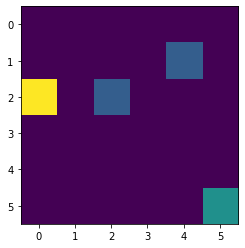

Episode 500
Epsilon 0.6063789448611848
***************************************************


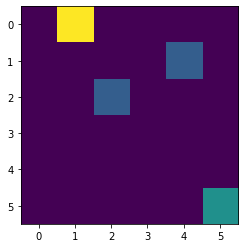

Episode 600
Epsilon 0.5486469074854965
***************************************************


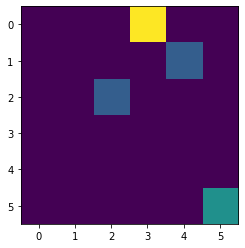

Episode 700
Epsilon 0.4964114134310989
***************************************************


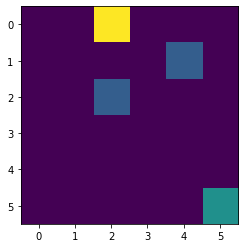

Episode 800
Epsilon 0.4491491486100748
***************************************************


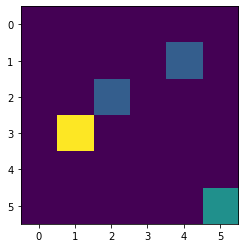

Episode 900
Epsilon 0.4063866225452039
***************************************************


In [28]:
# setting up environment and agent
env = DeterministicEnv()
agent = QlearningAgent(env,batch_size=64)
# agent = Agent(gamma=0.99,epsilon=1.0,batch_size=64,n_actions=4,
#               eps_end=0.01,input_dims=[8], lr=0.003)
episodes = 1000
min_epsilon = 0.1

q_d_epsilons = []
q_d_rewards = []

for episode in range(episodes):
  obs = env.reset()
  done = False
  q_d_epsilons.append(agent.epsilon)

  curr_reward = 0

  while not done:
    action = agent.step(obs)
    state = np.copy(obs)
    obs, reward, done, info = env.step(action)

    curr_reward+= reward
    next_state = np.copy(obs)
    # agent.update(state,action,reward,next_state)
    agent.store_transition(state,action,reward,next_state,done)
    agent.learn()

  q_d_rewards.append(curr_reward)
  epsilon = max(min_epsilon,agent.epsilon*0.999)
  agent.setEpsilon(epsilon)
  if not episode%100:
    env.render()
    plt.show()
    print('Episode {}'.format(episode))
    print('Epsilon {}'.format(q_d_epsilons[-1]))
    
    print('***************************************************')

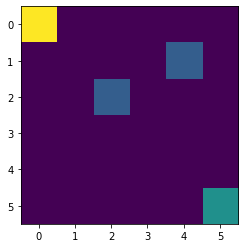

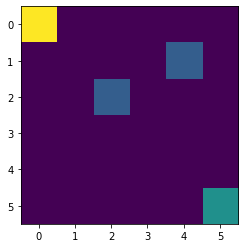

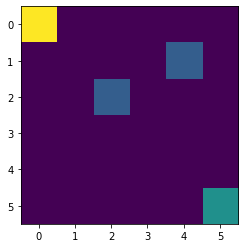

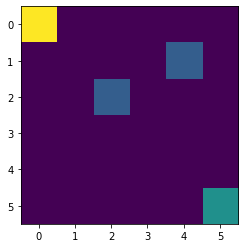

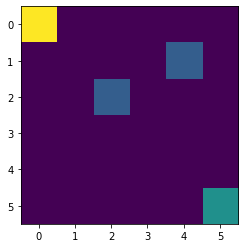

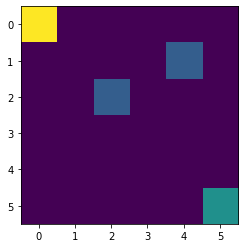

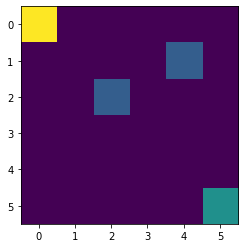

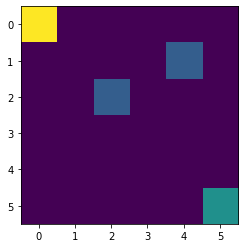

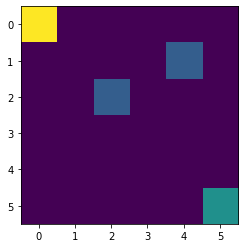

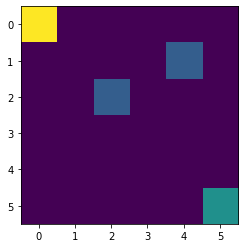

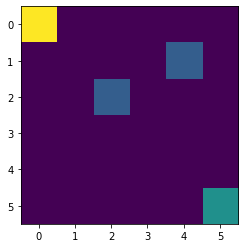

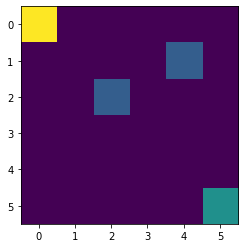

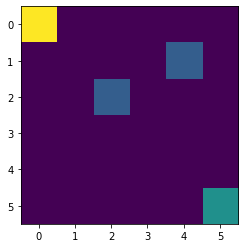

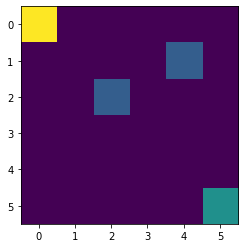

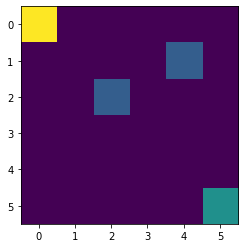

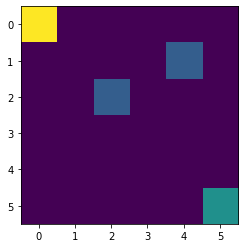

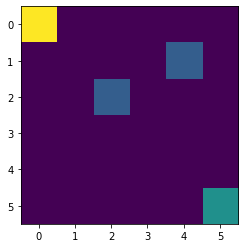

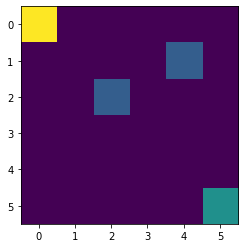

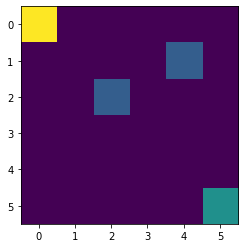

In [29]:
env = DeterministicEnv()

obs = env.reset()
done = False
agent.epsilon = 0
env.render()
plt.show()


while not done:
    action = agent.step(obs)
    obs, reward, done, info = env.step(action)
    env.render()
    plt.show()

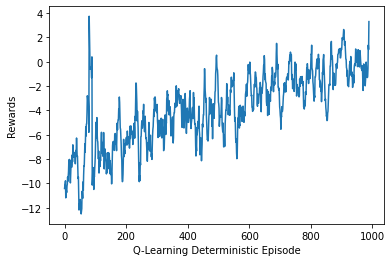

In [30]:
window = 10
plt.xlabel('Q-Learning Deterministic Episode')
plt.ylabel('Rewards')
plt.plot([np.mean(q_d_rewards[tr:tr+window]) for tr in range(window, len(q_d_rewards))])

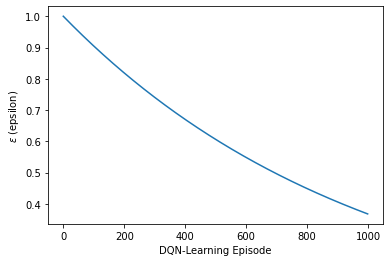

In [32]:
plt.xlabel('DQN-Learning Episode')
plt.ylabel('$\epsilon$ (epsilon)')
plt.plot(q_d_epsilons)